# Import & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# custom color palette
custom_palette = ["#EE4D2D", "#FF7340", "#FFA07A", "#A9A9A9", "#808080"]
sns.set_palette(custom_palette)

In [3]:
# load clean data
df = pd.read_csv('../data/processed/shopee_reviews_clean.csv')

# data cleaning verification
df['text_clean'] = df['text_clean'].fillna('').astype(str)
df = df[df['text_clean'].str.strip() != '']

print("Data cleaning verification completed!")
print(f"Jumlah data siap visualisasi: {len(df)}")

print("Data loaded successfully!")
display(df.head())

Data cleaning verification completed!
Jumlah data siap visualisasi: 19952
Data loaded successfully!


,review_text,rating,review_date,text_clean
0,padahal aku nyamaaan banget belaja disini tapi...,2,2025-11-27 19:34:34,padahal aku nyaman banget baja sini tapi opsi ...
1,bagus bangat,5,2025-11-27 19:34:17,bagus bangat
2,"semua oke sih, cuma saat saya mau ngasih ulasa...",5,2025-11-27 19:34:10,semua oke sih cuma mau ngasih ulas unggah vide...
3,mudah simpel cepat,5,2025-11-27 19:34:05,mudah simpel cepat
4,"maaf untuk sementara saya kasih bintang 1, kar...",1,2025-11-27 19:33:30,maaf kasih bintang beku akun lama banget buk p...


# Rating Distribution (The "Health Check")

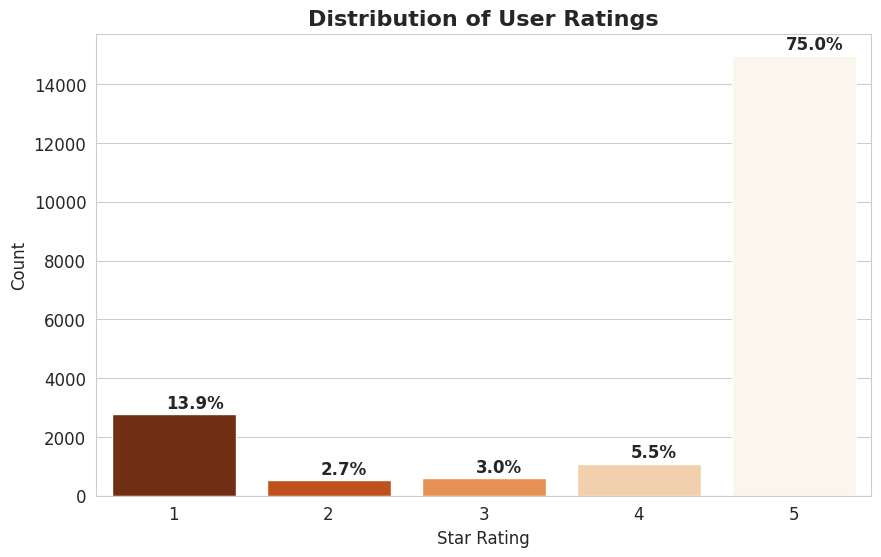

In [4]:
def plot_rating_distribution(df):
    plt.figure(figsize=(10, 6))
    
    ax = sns.countplot(
        x='rating', 
        data=df, 
        order=[1, 2, 3, 4, 5], 
        palette='Oranges_r', 
        hue='rating',
        legend=False
    )
    
    plt.title('Distribution of User Ratings', fontsize=16, fontweight='bold')
    plt.xlabel('Star Rating', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # add percentage labels
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        if pd.isna(height): 
            height = 0
            
        percentage = '{:.1f}%'.format(100 * height / total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = height + (total * 0.01) 
        
        ax.annotate(percentage, (x, y), size=12, fontweight='bold')
        
    plt.show()

plot_rating_distribution(df)

**Business Insight: High Polarization Risk.** While 75% of users are satisfied, **the 13.9% detractor rate (1-star)** significantly outweighs neutral ratings (2-4 stars combined). This suggests that users rarely face "minor inconveniences"; instead, they encounter critical failures (likely logistics or payment errors) that immediately drive satisfaction to zero.

# Sentiment Labeling (Creating the "Target Variable")

In [5]:
# create sentiment category based on rating
def categorize_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['rating'].apply(categorize_sentiment)

print("Sentiment Distribution:")
print(df['sentiment'].value_counts())

Sentiment Distribution:
sentiment
Positive    16065
Negative     3294
Neutral       593
Name: count, dtype: int64


# WordCloud Comparison (Positive vs Negative)

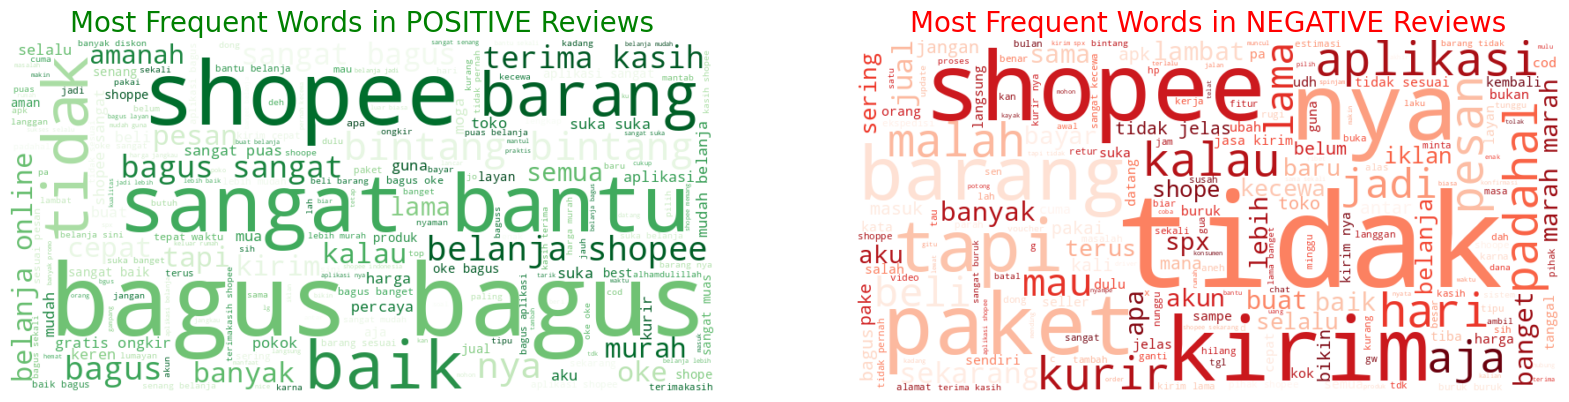

In [6]:
def plot_comparison_wordcloud(df):
    pos_df = df[df['sentiment'] == 'Positive']
    neg_df = df[df['sentiment'] == 'Negative']

    pos_text = ' '.join(pos_df['text_clean'])
    neg_text = ' '.join(neg_df['text_clean'])
    
    if len(pos_text) == 0: pos_text = "Data Kosong"
    if len(neg_text) == 0: neg_text = "Data Kosong"

    # WordCloud Setup
    wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(pos_text)
    wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(neg_text)
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    axes[0].imshow(wc_pos, interpolation='bilinear')
    axes[0].set_title('Most Frequent Words in POSITIVE Reviews', fontsize=20, color='green')
    axes[0].axis('off')
    
    axes[1].imshow(wc_neg, interpolation='bilinear')
    axes[1].set_title('Most Frequent Words in NEGATIVE Reviews', fontsize=20, color='red')
    axes[1].axis('off')
    
    plt.show()

# Jalankan Fungsi
plot_comparison_wordcloud(df)

### 💡 WordCloud Analysis: Decoding User Sentiment

The comparative WordCloud reveals a sharp distinction in user priorities:

1.  **The Logistics Bottleneck (Negative Cloud):**
    - The dominance of keywords like **`kirim`**, **`paket`**, **`kurir`**, and **`lama`** in the negative cloud strongly suggests that **Last-Mile Delivery** is the primary source of user churn. Users are less frustrated with the product itself, but highly agitated by the shipping process.
    - **`Aplikasi`** appears significantly in the negative sector, indicating technical instability (bugs, lag) is a major detractor.

2.  **Satisfaction Drivers (Positive Cloud):**
    - Positive reviews are product-centric (**`bagus`**, **`baik`**, **`mudah`**).
    - When the logistics ecosystem works efficiently ("cepat", "tepat waktu"), it becomes a key driver for 5-star ratings.

3.  **The Contextual "Tidak" (NLP Insight):**
    - The word **`tidak`** (no/not) is prominent in both sentiments. This validates tje decision to strictly handle stopwords.
    - In positive context: likely linked to *"tidak mengecewakan"* (not disappointing).
    - In negative context: likely linked to *"tidak sampai"* (didn't arrive) or *"tidak bisa"* (cannot use).
    - *Next Step:* will use **Bi-gram Analysis** to uncover the context behind these keywords.

# N-Gram Analysis

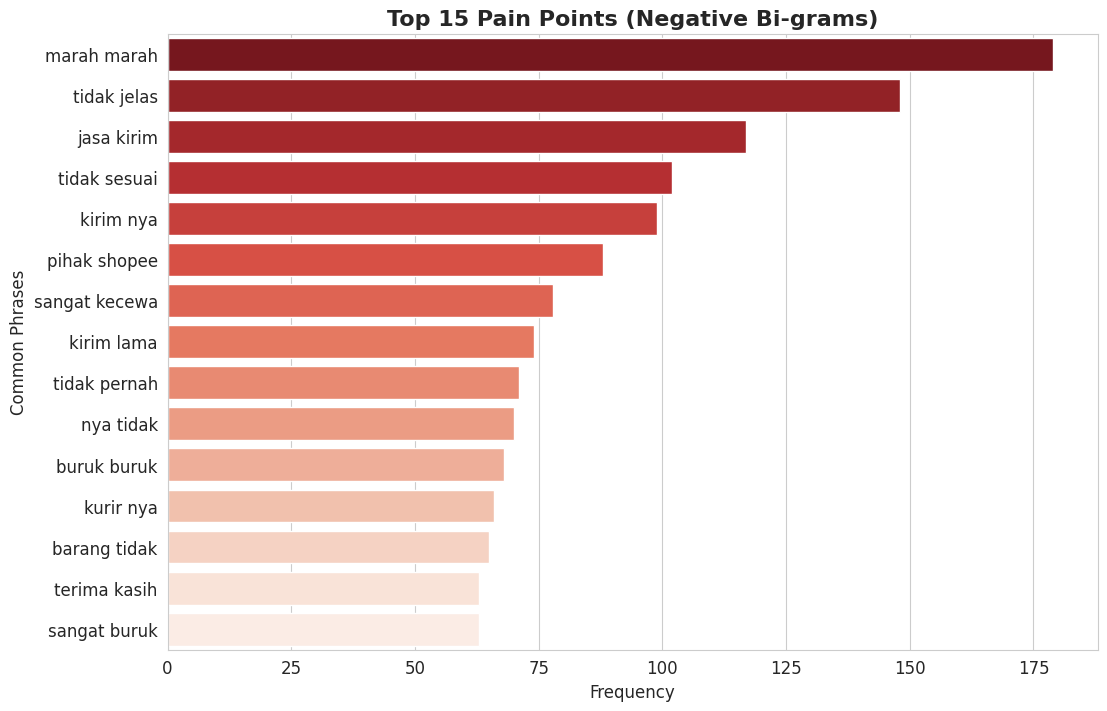

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=2, top_k=15):
    """
    Function to extract the most frequent phrases (Bi-gram/Tri-gram).
    """
    corpus = corpus.fillna('').astype(str)
    if len(corpus) == 0:
        return []

    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# extract Bi-grams from NEGATIVE reviews only
neg_reviews = df[df['sentiment'] == 'Negative']['text_clean']

# get top Bi-grams
top_bigrams_neg = get_top_ngrams(neg_reviews, n=2, top_k=15)

# visualize
if top_bigrams_neg:
    df_bigram = pd.DataFrame(top_bigrams_neg, columns=['Phrase', 'Frequency'])

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Frequency', 
        y='Phrase', 
        data=df_bigram, 
        palette='Reds_r',
        hue='Phrase',
        legend=False
    )
    plt.title('Top 15 Pain Points (Negative Bi-grams)', fontsize=16, fontweight='bold')
    plt.xlabel('Frequency')
    plt.ylabel('Common Phrases')
    plt.show()
else:
    print("Tidak cukup data untuk membuat Bi-gram.")

### Top 15 Negative Bi-grams (Pain Point Analysis)

While single keywords highlight general topics, Bi-grams reveal the specific contexts of user dissatisfaction:

1.  **The "Uncertainty" Factor (`tidak jelas`):**
    - Ranking #2, this indicates that **lack of information** (unclear tracking status, vague product descriptions) is almost as frustrating as the product quality itself. Users hate being kept in the dark.

2.  **Specific Logistics Complaints (`jasa kirim`, `kirim lama`):**
    - Users distinguish between the platform and the courier. The recurring mention of `jasa kirim` suggests dissatisfaction with specific logistics partners provided by the platform.

# Review Length Analysis (Do Angry Users Type More?)

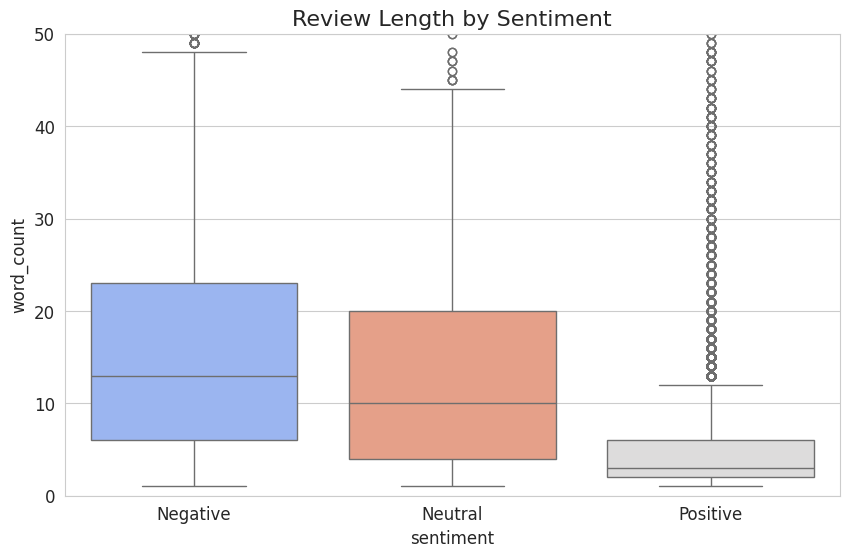

In [8]:
# count word length in each review
df['word_count'] = df['text_clean'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='sentiment',
    y='word_count', 
    data=df, 
    order=['Negative', 'Neutral', 'Positive'], 
    palette='coolwarm',
    hue = 'sentiment',
    legend = False
)
plt.title('Review Length by Sentiment', fontsize=16)
plt.ylim(0, 50)
plt.show()

### 📉 Review Length Analysis: The "Venting" Hypothesis

This Boxplot confirms a strong correlation between **Sentiment** and **Verbosity (Review Length)**:

1.  **Negative Reviews are Information-Rich (Median ~13 words):**
    - Dissatisfied users act as **"Storytellers"**. They tend to explain the *who, what, and why* of the failure (e.g., chronological order of shipping delay).
    - **Strategic Value:** For our LLM, negative reviews provide the most complex sentence structures and distinct entities (brand names, error types), making them crucial for training the model to understand context.

2.  **Positive Reviews are Transactional (Median ~4 words):**
    - Satisfied users are **"Minimalists"**. The extremely short Interquartile Range (IQR) indicates that the vast majority of 5-star reviews consist of short template phrases like *"Mantap"*, *"Bagus"*, or *"Sesuai pesanan"*.
    - **Implication:** While high in volume, positive reviews offer lower information density for extracting specific product features compared to negative reviews.

3.  **The "Super Fan" Anomalies:**
    - The outliers (dots) in the Positive sentiment represent valuable **detailed testimonials**. These users go beyond simple praise to describe product attributes in depth. Identifying and highlighting these reviews can significantly boost conversion rates.

## 🚀 Project Wrap-Up
This Exploratory Data Analysis (EDA) on ~20,000 user reviews has successfully profiled the "Voice of Customer" for the Shopee Indonesia App. The analysis moved beyond simple metrics to uncover structural patterns in user satisfaction and data quality.

### A. Key Findings (The "What")
1.  **Polarized Satisfaction:** The app enjoys a **75% satisfaction rate**, but faces a critical **13.9% hard-churn risk** (1-star ratings). The lack of "middle-ground" ratings indicates that failures are severe (deal-breakers), not minor.
2.  **The "Logistics" Scapegoat:** The primary driver for negative sentiment is **not the app features**, but the **Last-Mile Delivery ecosystem** (*kurir, paket, kirim lama*). Users often penalize the app for 3rd-party logistics failures.
3.  **The "Venting" Phenomenon:** Negative reviews are **3x longer** (median 13 words) than positive reviews. They contain rich, contextual narratives, whereas positive reviews are transactional and repetitive.

---

### B. Business Recommendations
*For Product & Engineering Teams:*

1.  **Transparency as a Feature:** Since `tidak jelas` (uncertainty) is a top pain point, the Product team should enhance the **Order Tracking UI**. providing more granular status updates can reduce anxiety even if delivery is slow.
2.  **Vendor Management:** The Data team can correlate specific *Logistics Providers* (J&T, SPX, etc.) with the `jasa kirim` complaints to flag underperforming partners.

---

### C. Implications for LLM Development
*For the Data Science / AI Team:*

#### 1. Dataset Balancing Strategy (Quality > Quantity)
* **The Problem:** The dataset is heavily imbalanced (75% Positive). Training an LLM on this raw data will result in a model that is **biased towards positivity** and lacks critical reasoning capabilities.
* **The Strategy:** We must **undersample** the short/generic positive reviews (e.g., "Mantap", "Bagus") and **oversample** the negative reviews.
* **Reasoning:** Negative reviews (The "Storytellers") provide the complex linguistic structures, entity relationships, and reasoning chains needed to make the LLM "smart."

#### 2. Instruction Tuning Potential
* The "Super Fan" outliers (long positive reviews) are rare but gold. These should be isolated to train the model on **"High-Quality Product Summarization"** tasks.
* The negative reviews containing specific error codes or logistics terms are ideal for Fine-Tuning a **"Customer Support Auto-Reply"** module.